In [1]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from pathlib import Path
import torch.nn as nn # for Neural Network
import torch
from sklearn.svm import SVR # SVR Model
import matplotlib.pyplot as plt #plotting
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score   # Evaluation
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor #decision tree

In [2]:
# Image Size
from PIL import Image

def get_total_pixel_size(image_path):
    try:
        # Open the image
        with Image.open(image_path) as img:
            # Get the size of the image
            width, height = img.size

            # Calculate the total pixel size
            total_pixels = width * height

            return total_pixels

    except Exception as e:
        print(f"Error: {e}")
        return None

# Example usage:
image_path = "Sat images/1984.png"
total_pixels = get_total_pixel_size(image_path)

if total_pixels is not None:
    print(f"The total pixel size of the image is: {total_pixels}")


The total pixel size of the image is: 833280


# Data Processing

In [3]:
def DF(directory):
    paths=pd.Series(list(directory.glob(r"*.png")),name="ImagPath").astype(str)
    return paths

Paths=Path("Sat Images")
Img=DF(Paths)

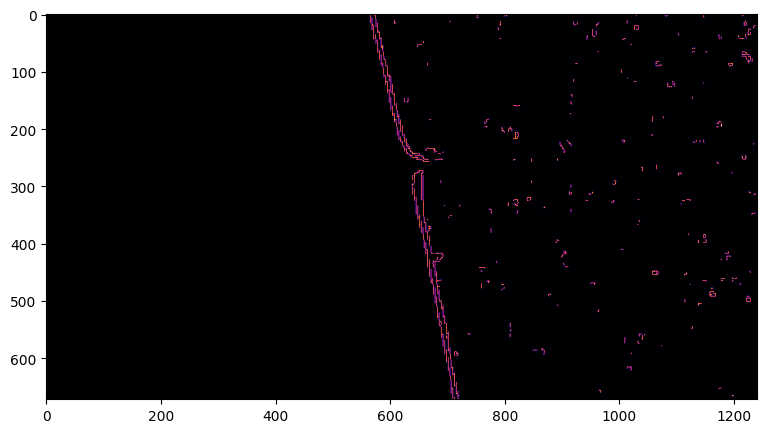

In [5]:
image=cv2.imread(Img[0],cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(image, (5, 5), 0)
edge = cv2.Canny(image, threshold1=250, threshold2=200)

plt.figure(figsize=(10,5))
plt.imshow(edge,cmap="inferno")
plt.show()

In [6]:
Edges = np.argwhere(edge== 255) #255 is the threshold, that would specify the algo to select the  extreme points only
DataP=np.array(Edges)

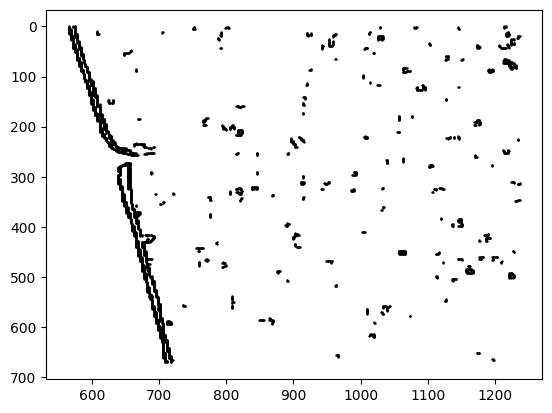

In [7]:
year=1984
df=pd.DataFrame(DataP)
df.columns=["Axis",year]
plt.figure()
plt.scatter(df[year],df["Axis"],s=0.5,color="Black" )
plt.gca().invert_yaxis()
plt.show()

In [8]:
df.to_csv("Test.csv",index=False)

In [9]:
year=1984
df=pd.DataFrame(DataP)
df.columns=["Axis",year]
df= df.drop_duplicates(subset=["Axis"]).reset_index(drop=True)

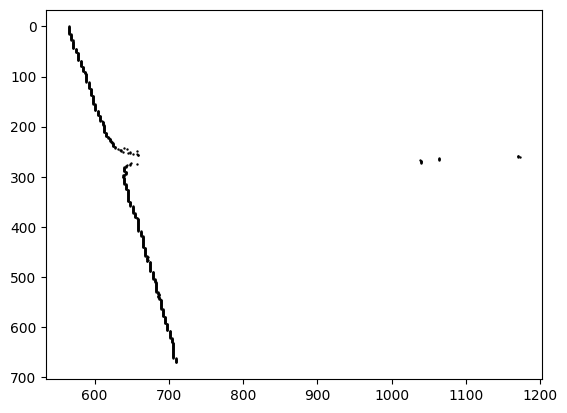

In [10]:
plt.figure()
plt.scatter(df[year],df["Axis"],s=0.5,color="Black" )
plt.gca().invert_yaxis()
plt.show()

In [11]:
df.to_csv("DF.csv",index=False)

In [12]:
for i in range(1,len(Img)):
    image=cv2.imread(Img[i],cv2.IMREAD_GRAYSCALE)
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    edge = cv2.Canny(image, threshold1=250, threshold2=200)
    edge_points = np.argwhere(edge == 255)
    Data_points=np.array(edge_points)
    ndf=pd.DataFrame(Data_points)
    year=1984+i
    ndf.columns=["Axis",year]
    ndf= ndf.drop_duplicates(subset=["Axis"]).reset_index(drop=True)
    df = pd.concat([df, ndf[year]], axis=1)
    df.to_csv("DF.csv",index=False)

In [13]:
Points=pd.read_csv("DF.csv")

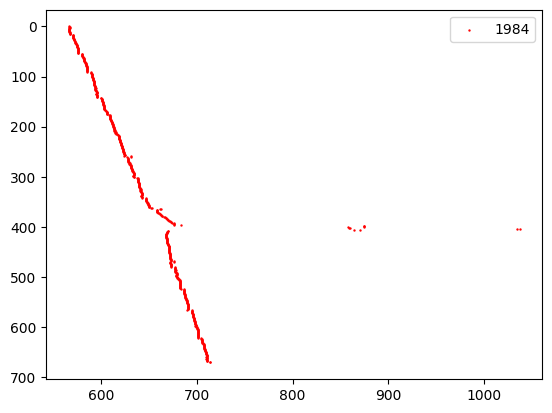

In [15]:
plt.figure()
plt.scatter(Points["2022"],Points["Axis"],s=0.5,color="Red",label="1984")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [16]:
#To handle the Null cell cases
for i in range(1984,2023):
    c=Points[str(i)]
    c.fillna(method="ffill",inplace=True)
    Points[str(i)]=c

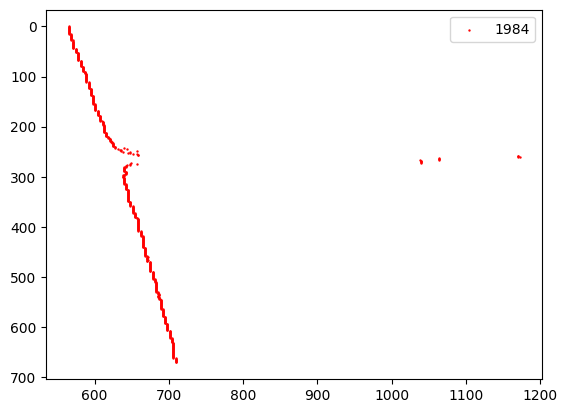

In [18]:
plt.figure()
plt.scatter(Points["1984"],Points["Axis"],s=0.5,color="Red",label="1984")
plt.scatter(Points["2022"],Points["Axis"],s=0.5,color="Blue",label="2022")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

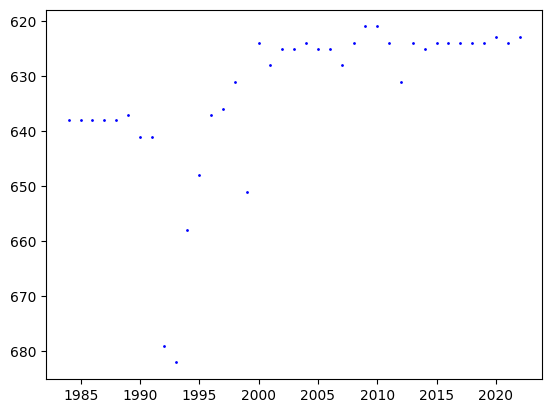

In [18]:
#for one row, a plot on how does the pixel loc change with year
y = np.array(Points.iloc[250][1:]).reshape(-1, 1)
years = np.array([i for i in range(1984, 2023)]).reshape(-1, 1)

plt.figure()
plt.scatter(years,y,s=1,color="blue" )
plt.gca().invert_yaxis()
plt.show()

# Model building - Linear Regression

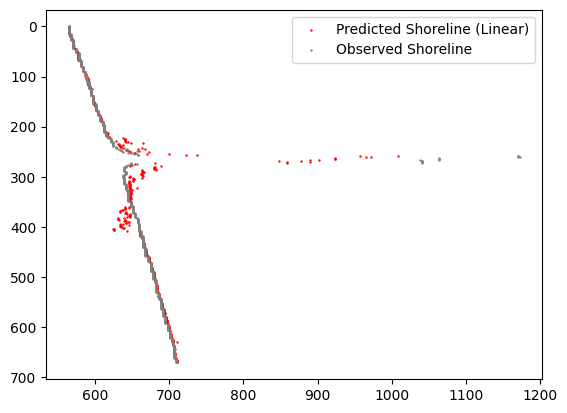

In [20]:
linear_models = []
for i in range(len(Points)):
    x = np.array(Points.iloc[i][1:]).reshape(-1, 1)
    years = np.array([i for i in range(1984, 2023)]).reshape(-1, 1)
    linear_model = LinearRegression()
    linear_model.fit(years, x)
    linear_models.append(linear_model)

def Prediction_linear(year):
    pred_points = []
    year = np.array([year]).reshape(-1, 1)
    for linear_model in linear_models:
        prediction = linear_model.predict(year)
        pred_points.append(prediction)
    return pred_points

plt.figure()
plt.scatter(Prediction_linear(1984), Points["Axis"], s=0.5, color="Red", label="Predicted Shoreline (Linear)")
plt.scatter(Points["1984"], Points["Axis"], s=0.5, color="Grey", label='Observed Shoreline')
plt.gca().invert_yaxis()
plt.legend()
plt.show()


### Evaluation of LR

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

ground_truth = Points["2000"]
predicted_shoreline_linear = np.array(Prediction_linear(2000)).flatten()

mae_linear = mean_absolute_error(ground_truth, predicted_shoreline_linear)
mse_linear = mean_squared_error(ground_truth, predicted_shoreline_linear)
r2_linear = r2_score(ground_truth, predicted_shoreline_linear)

accuracy_percentage_linear = (1 - mae_linear / ground_truth.mean()) * 100

print(f'Mean Absolute Error (MAE) Linear Regression: {mae_linear}')
print(f'Mean Squared Error (MSE) Linear Regression: {mse_linear}')
print(f'R-squared (R2) Linear Regression: {r2_linear}')
print(f'Accuracy Linear Regression: {accuracy_percentage_linear:.2f}%')


Mean Absolute Error (MAE) Linear Regression: 7.975367103656577
Mean Squared Error (MSE) Linear Regression: 505.8746708471751
R-squared (R2) Linear Regression: 0.770817270009797
Accuracy Linear Regression: 98.76%


# Model Building - SVR

In [21]:
rbf_models = []
C=Points["1984"].mean()
for i in range(len(Points)):
    x = np.array(Points.iloc[i][1:]).reshape(-1, 1)
    years = np.array([i for i in range(1984, 2023)]).reshape(-1, 1)
    rbf_model = SVR(kernel='rbf',C=C,gamma=0.1)
    rbf_model.fit(years, x)
    rbf_models.append(rbf_model)

c:\python3.10\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\python3.10\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\python3.10\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\python3.10\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1

In [22]:
def Prediction_svr(year):
    pred_points = []
    year = np.array([year]).reshape(-1, 1)
    for rbf_model in rbf_models:
        prediction = rbf_model.predict(year)
        pred_points.append(prediction)
    return pred_points


In [23]:
Prediction_svr(2010)

[array([562.63963442]),
 array([562.61665221]),
 array([562.57109962]),
 array([562.36240993]),
 array([563.89325909]),
 array([563.53009424]),
 array([564.0551804]),
 array([564.63019712]),
 array([564.56793277]),
 array([563.33063564]),
 array([564.09979491]),
 array([564.09976263]),
 array([564.10019612]),
 array([564.0995987]),
 array([564.09960664]),
 array([564.1000414]),
 array([564.09946803]),
 array([565.10001896]),
 array([565.10027841]),
 array([565.10022447]),
 array([564.99187829]),
 array([564.8996825]),
 array([565.00327424]),
 array([565.61800174]),
 array([565.83779479]),
 array([565.64553924]),
 array([568.50717948]),
 array([568.10013837]),
 array([568.09938762]),
 array([568.10028278]),
 array([567.89980731]),
 array([568.21403893]),
 array([567.90043471]),
 array([567.90040648]),
 array([567.9003594]),
 array([568.09971162]),
 array([571.23145809]),
 array([570.81217509]),
 array([570.56870401]),
 array([570.50674711]),
 array([570.3539689]),
 array([570.72710713])

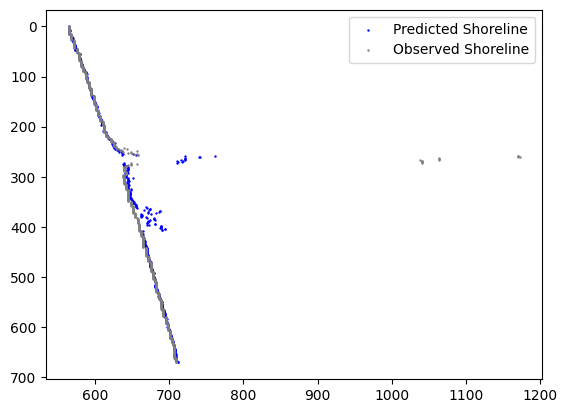

In [25]:
plt.figure()
plt.scatter(Prediction_svr(2040),Points["Axis"],s=0.5,color="Blue",label="Predicted Shoreline")
plt.scatter(Points["1984"],Points["Axis"],s=0.5,color="Grey",label='Observed Shoreline')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

### SVR- Model Evaluation

In [26]:
ground_truth = Points["1984"]

predicted_shoreline = np.array(Prediction_svr(1984)).flatten()

mae = mean_absolute_error(ground_truth, predicted_shoreline)
mse = mean_squared_error(ground_truth, predicted_shoreline)
r2 = r2_score(ground_truth, predicted_shoreline)

accuracy_percentage = (1 - mae / ground_truth.mean()) * 100

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')
print(f'Accuracy SVR: {accuracy_percentage:.2f}%')


Mean Absolute Error (MAE): 0.1292873181909525
Mean Squared Error (MSE): 0.6823944132908795
R-squared (R2): 0.9998841103895449
Accuracy SVR: 99.98%


# Neural Network

In [27]:
#Neural Network

class NNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [28]:
input_size = 39   # number of x input features
hidden_size = 23
num_classes = 1

nn_models = []
for i in range(len(Points)):
    x = torch.Tensor(Points.iloc[i][1:]).view(1, -1)
    years = torch.Tensor([i for i in range(1984, 2023)]).view(1, -1)

    model = NNModel(input_size, hidden_size, num_classes)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(100):
        optimizer.zero_grad()
        output = model(years)
        loss = criterion(output, x)
        loss.backward()
        optimizer.step()

    nn_models.append(model)

c:\python3.10\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 39])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [29]:
def Prediction_nn(year):
    pred_points = []
    year = torch.Tensor([list(year for _ in range(input_size))]).view(1, -1)
    for model in nn_models:
        prediction = model(year)
        pred_points.append(prediction.item())
    return pred_points

In [30]:
Prediction_nn(2000)

[555.083251953125,
 555.1422729492188,
 555.8975219726562,
 552.029541015625,
 566.2230224609375,
 563.3335571289062,
 558.8173828125,
 555.4531860351562,
 558.4017944335938,
 562.7872314453125,
 560.7764892578125,
 568.0695190429688,
 562.7957153320312,
 561.9508666992188,
 562.4415893554688,
 565.4794921875,
 566.3644409179688,
 564.93701171875,
 569.3543701171875,
 562.9979248046875,
 565.042236328125,
 565.289794921875,
 566.2667846679688,
 567.7980346679688,
 570.1024780273438,
 568.9603271484375,
 565.1610107421875,
 570.85546875,
 577.3475952148438,
 567.9935913085938,
 571.3115234375,
 566.2867431640625,
 568.9188232421875,
 572.0481567382812,
 569.4656372070312,
 567.1349487304688,
 566.646240234375,
 573.4531860351562,
 571.2889404296875,
 570.0489501953125,
 573.3798217773438,
 573.4569091796875,
 568.9991455078125,
 572.193603515625,
 571.608154296875,
 572.47998046875,
 577.4869384765625,
 574.6694946289062,
 572.5880126953125,
 568.1271362304688,
 572.6622314453125,
 568.

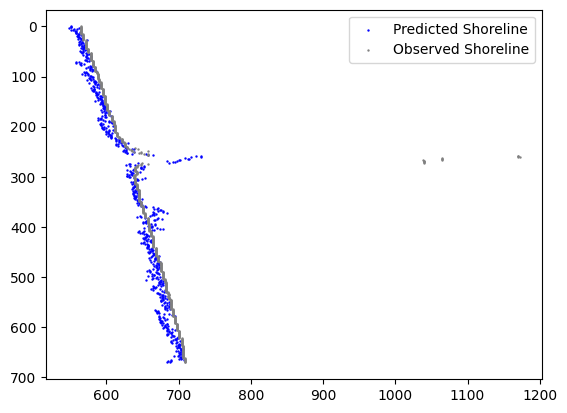

In [31]:
plt.figure()
plt.scatter(Prediction_nn(1984),Points["Axis"],s=0.5,color="Blue",label="Predicted Shoreline")
plt.scatter(Points["1984"],Points["Axis"],s=0.5,color="Grey",label='Observed Shoreline')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

### NN - Evaluation

In [39]:
ground_truth = Points["2020"]

predicted_shoreline = np.array(Prediction_nn(2040)).flatten()

mae = mean_absolute_error(ground_truth, predicted_shoreline)
mse = mean_squared_error(ground_truth, predicted_shoreline)
r2 = r2_score(ground_truth, predicted_shoreline)

accuracy_percentage = (1 - mae / ground_truth.mean()) * 100

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')
print(f'Accuracy NN: {accuracy_percentage:.2f}%')


Mean Absolute Error (MAE): 15.51420535748115
Mean Squared Error (MSE): 2012.6208632727303
R-squared (R2): 0.06935564643868009
Accuracy NN: 97.59%


# Decison Tree regression model:


In [40]:
dec_models = []
for i in range(len(Points)):
    x = np.array(Points.iloc[i][1:]).reshape(-1, 1)
    years = np.array([i for i in range(1984, 2023)]).reshape(-1, 1)
    dec_model = XGBRegressor()
    dec_model.fit(years, x)
    dec_models.append(dec_model)

In [34]:
def Prediction_dt(year):
    pred_points = []
    year = np.array([year]).reshape(-1, 1)
    for dec_model in dec_models:
        prediction = dec_model.predict(year)
        pred_points.append(prediction)
    return pred_points

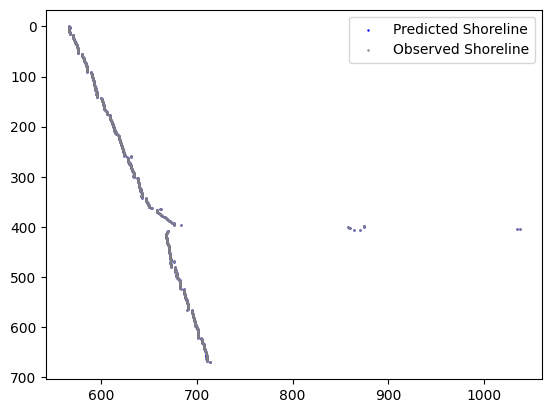

In [52]:
plt.figure()
plt.scatter(Prediction_dt(1984),Points["Axis"],s=0.5,color="Blue",label="Predicted Shoreline")
plt.scatter(Points["2022"],Points["Axis"],s=0.5,color="Grey",label='Observed Shoreline')
plt.gca().invert_yaxis()
plt.legend()
plt.show()